In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
from scipy import stats

In [3]:
sns.set_context('talk')

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [6]:
dfXtrain = pd.read_csv('preprocessed_csv/train_tree.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_tree.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_tree.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [7]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Заполним пропуски в департаменте

In [8]:
dfXtrain.department = dfXtrain.department.fillna(method='ffill')
dfXtrain.subreg = dfXtrain.subreg.fillna(method='ffill')

Вынесем var14, department и subreg.

In [9]:
dropped_col_names = ['var14', 'department', 'subreg'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [953]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

In [954]:
dropped_train.isnull().sum()

var14         0
department    0
subreg        0
dtype: int64

Декодируем оставшиеся категориальные признаки

In [955]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [956]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [957]:
for col in categorical:
    print(col, train[col].nunique())

marque 154
energie_veh 5
profession 17
var6 5
var8 23


energie_veh и var6 с помощью get_dummies

In [958]:
small_cat = ['energie_veh', 'var6']

In [959]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Для остальных посчитаем сглаженные средние таргета

In [960]:
big_cat = ['marque', 'profession', 'var8']

Описание для начала

In [961]:
df = pd.concat([dfYtrain.describe()] + [train[col].value_counts().describe() for col in big_cat], axis=1)
df

,COTIS,marque,profession,var8
count,300000.000000,154.000000,17.000000,23.000000
mean,346.063566,1946.168831,17647.058824,13018.000000
std,119.870510,8040.202889,29867.244501,24502.085807
min,94.780000,1.000000,393.000000,1.000000
25%,262.050000,3.000000,2610.000000,775.000000
50%,323.220000,11.500000,5829.000000,2208.000000
75%,407.500000,359.750000,13273.000000,7045.000000
max,1518.810000,73371.000000,110354.000000,91826.000000


Сглаживать будем с 500

Будем использовать среднее, 25%, 50% и 75%

Декодирование

In [962]:
class EncodeWithAggregates():

    def __init__(self, cols, y_train, train, *tests, smooth_coef=None):
        self.cols = cols
        self.y_train = y_train
        self.train = train
        self.tests = tests
        self.Xs = (self.train,) + self.tests
        
        self.miss_val = 'NAN'
        self.percentiles = [25, 50, 75]
        self.names = ['Mean'] + [str(q) for q in self.percentiles]
        self.aggs = [np.mean] + [self.percentile_fix(q) for q in self.percentiles]
        self.miss_val_fills = [agg(y_train) for agg in self.aggs]
        self.train_aggs = [agg(y_train) for agg in self.aggs]
        if smooth_coef:
            self.smooth_coef = smooth_coef
        else:
            self.smooth_coef = {col: 0 for col in cols}
        

    def percentile_fix(self, q):
        def wrapped(a):
            return np.percentile(a, q)

        return wrapped
        
    
    def transform(self):
        for col in self.cols:
            self.encode(col)
            gc.collect()
        return self.Xs
    
    
    def encode(self, col):
        df = pd.concat([self.y_train, self.train[col]], axis=1)
        dfgb = df.groupby(col)
        dfsize = dfgb.size()
        dfsize.ix[self.miss_val] = 0

        for X in self.Xs:                
            agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
            agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
            agg_name = "{}_{}".format(col, 'size')
            X[agg_name] = agg_size

        for name, agg, miss_val_fill, train_agg in zip(self.names, self.aggs, self.miss_val_fills, self.train_aggs):
            dfm = dfgb.agg(agg)
            dfm.ix[self.miss_val] = miss_val_fill
            for X in self.Xs:                
                agg_df = dfm.ix[X[col].fillna(self.miss_val)].set_index(X.index)[self.y_train.name]
                agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
                agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
                agg_name = "{}_{}".format(col, name)
                X[agg_name] = (agg_df * agg_size + self.smooth_coef[col] * train_agg) / (self.smooth_coef[col] + agg_size)
        
        self.Xs = [X.drop(col, axis=1) for X in self.Xs]

In [963]:
smooth_coef = {'profession': 0, 'var8': 500, 'marque': 500}

train, test = EncodeWithAggregates(big_cat, dfYtrain['COTIS'], train, test, smooth_coef=smooth_coef).transform()

In [964]:
test.shape

(30000, 51)

In [965]:
train.shape

(300000, 51)

In [966]:
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

In [967]:
y_train = np.array(dfYtrain)
x_train = np.array(train)
x_test = np.array(test)

In [27]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(train.crm, dfYtrain.COTIS)

In [29]:
slope, intercept, rvalue, pvalue, stderr

(3.4019808086311301,
 95.841221149398137,
 0.67260296056871227,
 0.0,
 0.0068335709763392965)

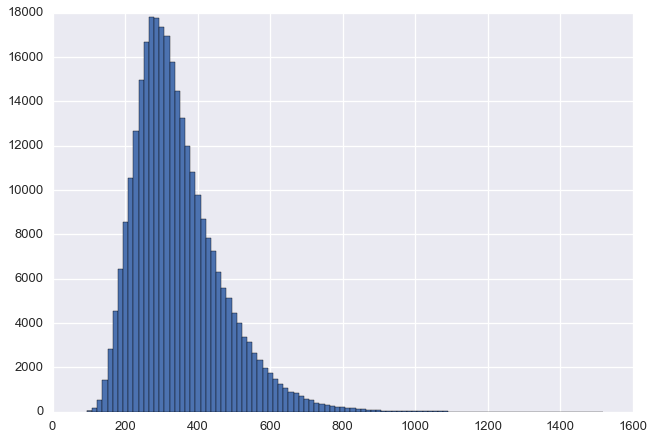

In [31]:
dfYtrain.COTIS.hist(bins=100)

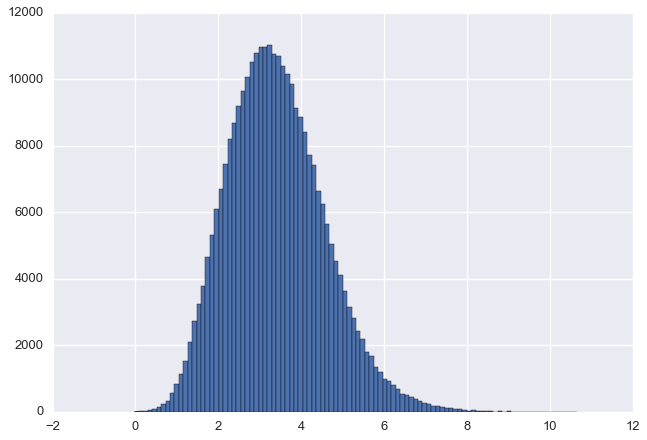

In [32]:
((dfYtrain.COTIS - intercept) / train.crm).hist(bins=100)

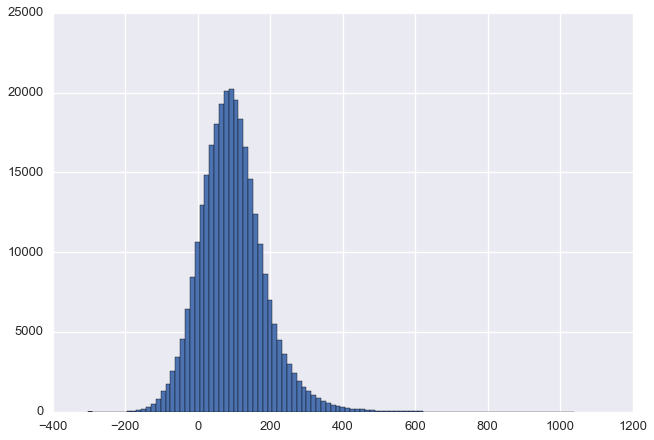

In [62]:
(dfYtrain.COTIS - slope * train.crm).hist(bins=100)

In [33]:
train.shape

(300000, 51)

In [36]:
train.drop('crm', axis=1).drop_duplicates().shape

(299971, 50)

In [39]:
train[train.drop('crm', axis=1).duplicated(keep=False)]

,annee_naissance,annee_permis,puis_fiscale,anc_veh,kmage_annuel,crm,var1,var2,var3,var4,var5,var7,var9,var10,var11,var12,var13,var15,var16,var17,var18,var19,var20,var21,var22,permis_age,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N,marque_size,marque_Mean,marque_25,marque_50,marque_75,profession_size,profession_Mean,profession_25,profession_50,profession_75,var8_size,var8_Mean,var8_25,var8_50,var8_75
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20807,1988.0,2007.0,5,1,2837,112,9.0,5,372,0,1,1.0,60,162,1,805,3,3,1.0,1,27,0,0,1,1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,66389,358.238655,264.680191,335.825067,428.769809
20808,1988.0,2007.0,5,1,2837,106,9.0,5,372,0,1,1.0,60,162,1,805,3,3,1.0,1,27,0,0,1,1,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,66389,358.238655,264.680191,335.825067,428.769809
72227,1989.0,2008.0,7,2,7056,62,8.0,1,372,0,2,10.0,115,187,2,1245,5,0,1.0,2,24,0,0,1,5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305
72228,1989.0,2008.0,7,2,7056,58,8.0,1,372,0,2,10.0,115,187,2,1245,5,0,1.0,2,24,0,0,1,5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305
73260,1993.0,2012.0,5,2,2683,50,4.0,3,372,0,1,4.0,51,150,2,720,3,0,1.0,2,24,3,0,1,0,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,1137,325.568734,244.0800,313.770,390.4400,23369,296.880304,221.429119,280.141698,350.352716
73261,1993.0,2012.0,5,2,2683,50,4.0,3,372,0,1,4.0,51,150,2,720,3,0,1.0,2,24,3,0,1,0,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35086,340.844844,259.419980,319.330429,402.629409,1137,325.568734,244.0800,313.770,390.4400,23369,296.880304,221.429119,280.141698,350.352716
79179,1989.0,2008.0,6,17,7443,85,8.0,3,272,0,2,1.0,110,200,17,1385,5,3,1.0,1,22,0,0,1,2,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,15624,333.513677,253.1075,313.480,390.2275,54018,349.780423,269.352408,326.464964,408.151470
79180,1989.0,2008.0,6,17,7443,90,8.0,3,272,0,2,1.0,110,200,17,1385,5,3,1.0,1,22,0,0,1,2,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,15624,333.513677,253.1075,313.480,390.2275,54018,349.780423,269.352408,326.464964,408.151470
90599,1983.0,2002.0,7,1,7149,63,14.0,5,372,0,1,10.0,90,170,1,1278,5,1,1.0,2,37,2,0,1,0,19.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,73371,336.598258,253.334394,314.509360,398.650308,110354,360.052820,272.2800,330.370,424.3775,91826,363.817658,274.902517,341.808783,430.492305


In [58]:
first = (train[train.drop('crm', axis=1).duplicated(keep='last')]).index
second = (train[train.drop('crm', axis=1).duplicated(keep='first')]).index
slopes = (np.array(dfYtrain.COTIS[second]) - np.array(dfYtrain.COTIS[first])) / \
            (np.array(train.crm[second]) - np.array(train.crm[first]))
intercepts = np.array(dfYtrain.COTIS[first]) - slopes * np.array(train.crm[first])

In [59]:
slopes[~np.isnan(slopes)]

array([ 3.83833333,  5.41      ,  3.68      ,  4.125     ,  4.55      ,
        4.66333333,  2.13      ,  5.01      ,  4.725     ,  3.59      ,
        4.2975    ,  2.89      ,  4.665     ,  4.43277778,  2.528     ,
        4.503     ])

In [60]:
intercepts[~np.isnan(intercepts)]

array([  57.49666667,   59.73      ,   21.11      ,   52.605     ,
        111.92      ,   37.89666667,   69.67      ,   79.71      ,
         74.39      ,   43.59      ,   72.55      ,   90.76      ,
         36.45      ,   52.62222222,  109.81      ,   46.06      ])

In [61]:
intercepts[~np.isnan(intercepts)] / slopes[~np.isnan(slopes)]

array([ 14.97959184,  11.04066543,   5.73641304,  12.75272727,
        24.5978022 ,   8.12651894,  32.70892019,  15.91017964,
        15.74391534,  12.14206128,  16.88190809,  31.40484429,
         7.81350482,  11.8711618 ,  43.4375    ,  10.2287364 ])

In [83]:
9 * 4 * 5 * 5 * 2 * 5 * 2

18000

У наклона не очень большой разброс, поэтому можно взять средний наклон за начальное приближение и предсказать пересечение.

In [89]:
slopes[~np.isnan(slopes)] - slope

array([ 0.43635252,  2.00801919,  0.27801919,  0.72301919,  1.14801919,
        1.26135252, -1.27198081,  1.60801919,  1.32301919,  0.18801919,
        0.89551919, -0.51198081,  1.26301919,  1.03079697, -0.87398081,
        1.10101919])

Ограничим добавку к наклону двойкой по модулю

In [90]:
intercepts[~np.isnan(intercepts)] - intercept

array([-38.34455448, -36.11122115, -74.73122115, -43.23622115,
        16.07877885, -57.94455448, -26.17122115, -16.13122115,
       -21.45122115, -52.25122115, -23.29122115,  -5.08122115,
       -59.39122115, -43.21899893,  13.96877885, -49.78122115])

Завышение среднего intercept можно отыграть добавкой к наклону.

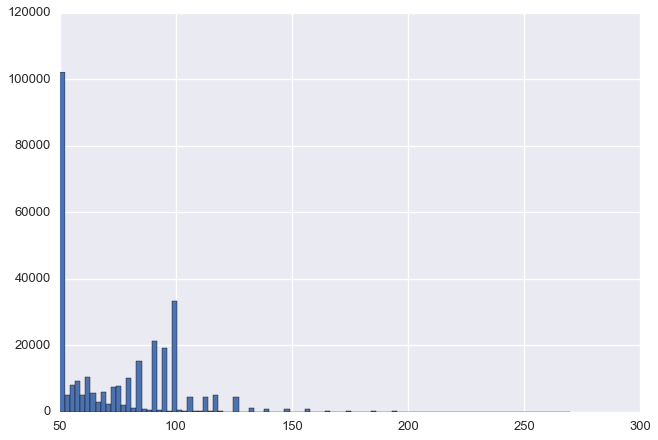

In [91]:
train.crm.hist(bins=100)

In [92]:
train.crm.value_counts().head()

50     95427
100    33270
90     20738
95     18909
85     14623
Name: crm, dtype: int64

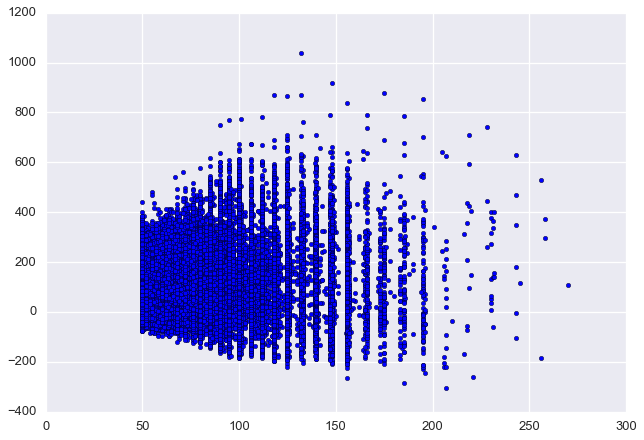

In [93]:
plt.scatter(train.crm, (dfYtrain.COTIS - slope * train.crm))

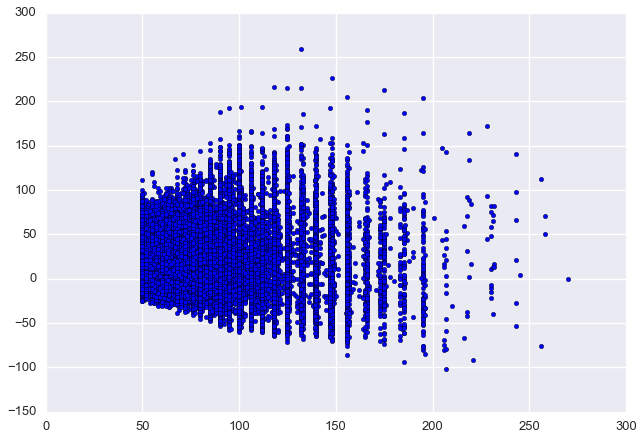

In [944]:
plt.scatter(train.crm, (dfYtrain.COTIS - slope * train.crm) / slope)

In [95]:
slopes = slopes[~np.isnan(slopes)]
intercepts = intercepts[~np.isnan(intercepts)]

In [101]:
slopes.mean(), intercepts.mean()

(4.0648715277777754, 63.523159722222424)

In [102]:
slope, intercept

(3.4019808086311301, 95.841221149398137)

(array([ 1.,  1.,  1.,  0.,  2.,  1.,  2.,  6.,  1.,  1.]),
 array([ 2.13 ,  2.458,  2.786,  3.114,  3.442,  3.77 ,  4.098,  4.426,
         4.754,  5.082,  5.41 ]),
 <a list of 10 Patch objects>)

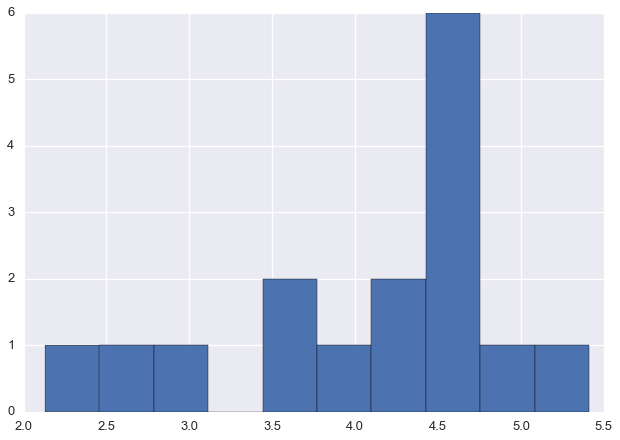

In [104]:
plt.hist(slopes)

(array([ 1.,  2.,  2.,  2.,  2.,  3.,  1.,  1.,  0.,  2.]),
 array([  21.11 ,   30.191,   39.272,   48.353,   57.434,   66.515,
          75.596,   84.677,   93.758,  102.839,  111.92 ]),
 <a list of 10 Patch objects>)

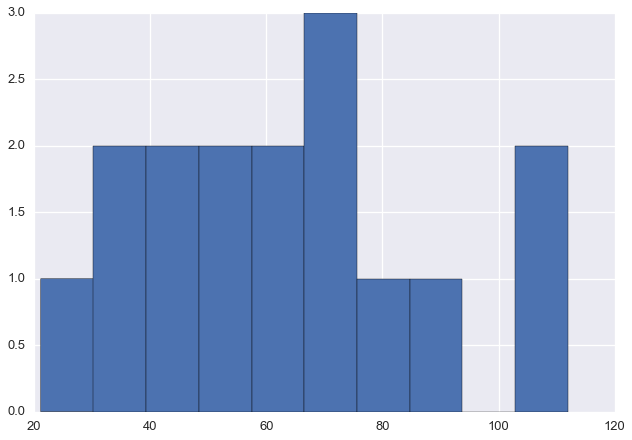

In [105]:
plt.hist(intercepts)

In [899]:
def new_diff(zero_apprx):
    return np.minimum((zero_apprx - 100) * 0.44 / train.crm, 3) + \
           np.minimum((zero_apprx - 20) * 0.44 / train.crm, 3)

In [900]:
def squeeze(apprx, number):
    for i in range(number):
        diff = new_diff(apprx)
        apprx = apprx - diff * train.crm
    return apprx


In [901]:
slope = 3.4019808086311301 #средний по всем
slope = 4.0648715277777754 #средний по дублям
slope = 3.8

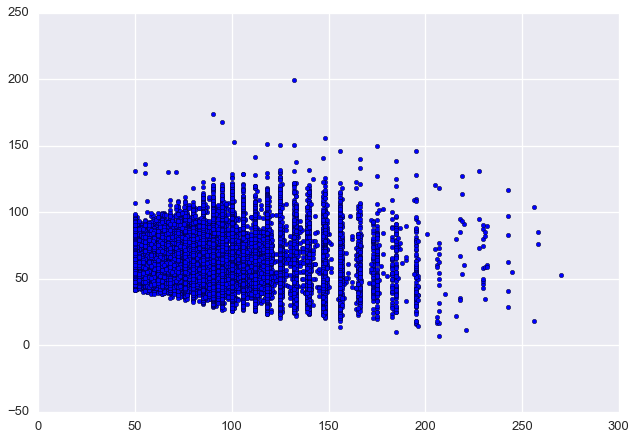

In [1035]:
zero_apprx = (dfYtrain.COTIS - slope * train.crm)
inters = squeeze(zero_apprx, 1)
#inters = zero_apprx
plt.scatter(train.crm, inters)

In [1036]:
zero_apprx = (dfYtrain.COTIS - slope * train.crm)
diff = new_diff(zero_apprx)

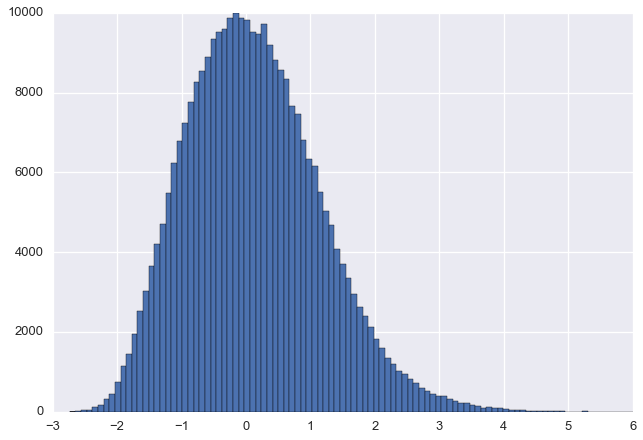

In [1037]:
plt.hist(diff, bins=100)
plt.show()

Теперь у нас есть нулевое приближение для diff

# Save routines

In [181]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [182]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [183]:
model_name = 'lin_crm'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,lin_crm
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [184]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train XGB

In [371]:
import xgboost as xgb
XGBR = xgb.XGBRegressor
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

In [186]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [187]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [188]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [189]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [1091]:
mape(y_train[:, 0], 60 + train.crm * (slope + diff))

-2.4779370292308642

In [879]:
intercept = 60

In [880]:
def grid_search(x_train, y_train, scorer):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':5,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':1, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    diff_num_round_list = [4 for i in range(4)]
    diff_num_round_list[0] = 6
    num_round_list = np.cumsum(diff_num_round_list)
    n_folds = 3

    mygs = MyGS(num_round_list, 'num_round', n_folds=n_folds)

    y_pred_all = np.zeros(y_train.shape)

    label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)

    for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
        dtrain = xgb.DMatrix(x_train[train_index], 
                             label=y_train[train_index], 
                             missing=-9999,) 
        dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
        param['base_score'] = np.mean(y_train[train_index])
        bst = None
        for index, diff_num_round in enumerate(diff_num_round_list):
            bst = xgb.train(param, dtrain, diff_num_round, xgb_model=bst)
            y_pred = bst.predict(dvalidation)
            score = scorer(y_pred, test_index)
            mygs.add(score, index)
        y_pred_all[test_index, 0] = y_pred
        gc.collect()
    
    return mygs, y_pred_all

In [881]:
def scorer(y_pred, test_index):
    return mape(y_train[test_index][:, 0], intercept + train.crm[test_index] * (slope + y_pred))

In [882]:
my_columns = ['anc_veh', 'kmage_annuel', 'annee_permis', 'var12', 'var4', 'marque_25',
       'var1', 'var5', 'var10', 'var18', 'var9', 'annee_naissance', 'crm',
       'marque_size', 'energie_veh_gazole']

In [883]:
x_train_col = np.array(train[my_columns])

In [887]:
%%time
mygs, diff_pred = grid_search(x_train_col, diff.reshape(y_train.shape), scorer)


CPU times: user 19.6 s, sys: 84 ms, total: 19.7 s
Wall time: 19.7 s


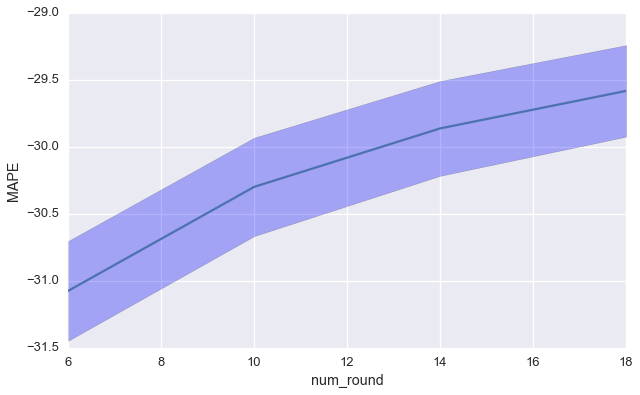

In [888]:
plot_quality(mygs, 'num_round')

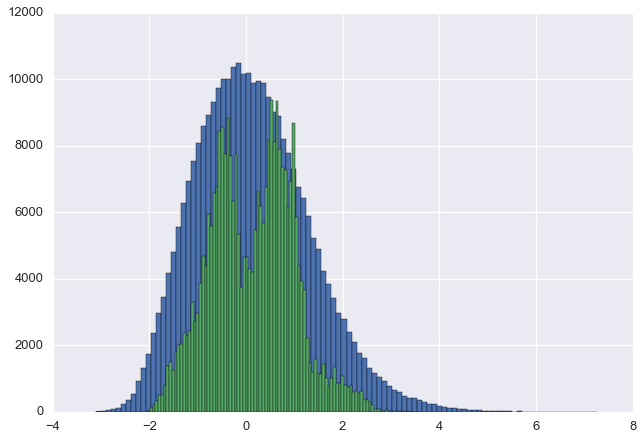

In [889]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

In [948]:
scaler = StandardScaler().fit(x_train_col)
x_scaled = scaler.transform(x_train_col)

In [949]:
%%time
train = 250 * 1000

svr = SGD(loss='epsilon_insensitive', penalty='elasticnet',
          epsilon=0.0, random_state=42, n_iter=5, alpha=0.0001, eta0=0.1).fit(x_scaled[:train], y_train[:train, 0])

CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 515 ms


In [950]:
y_pred = svr.predict(x_scaled[train:])
mape(y_train[train:, 0], y_pred)

-16.202779597832361

In [989]:
my_columns

['anc_veh',
 'kmage_annuel',
 'annee_permis',
 'var12',
 'var4',
 'marque_25',
 'var1',
 'var5',
 'var10',
 'var18',
 'var9',
 'annee_naissance',
 'crm',
 'marque_size',
 'energie_veh_gazole']

In [1010]:
wow_df = train[my_columns].copy()
wow_df['crm'] = np.log(wow_df['crm'])

x_train_wow = np.array(wow_df)
scaler = StandardScaler().fit(x_train_wow)
x_scaled = scaler.transform(x_train_wow)

In [1033]:
%%time
train_index = 250 * 1000
inter = 60

wow = np.log(y_train[:, 0] - inter)

svr = SGD(loss='epsilon_insensitive', penalty='elasticnet',
          epsilon=0.0, random_state=42, n_iter=5, alpha=0.0001, eta0=0.1).fit(x_scaled[:train_index], wow[:train_index])

CPU times: user 568 ms, sys: 4 ms, total: 572 ms
Wall time: 572 ms


In [1034]:
wow_pred = svr.predict(x_scaled[train_index:])
y_pred = np.exp(wow_pred) + inter
mape(y_train[train_index:, 0], y_pred)

-19.941254549886921

In [695]:
from sklearn.ensemble import AdaBoostRegressor

In [833]:
%%time
train_index = 250 * 1000
est = AdaBoostRegressor(n_estimators=50).fit(X=x_train_col[:train_index,:], y=diff[:train_index])

CPU times: user 39.9 s, sys: 32 ms, total: 39.9 s
Wall time: 39.9 s


In [834]:
y_pred = (est.predict(x_train_col[train_index:, :]) + slope) * train.crm[train_index:] + intercept
mape(y_train[train_index:, 0], y_pred)

-13.817738653429226

In [714]:
from sklearn.ensemble import RandomForestRegressor

In [1050]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict(X)
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, (rf_prediction + slope) * train.crm + intercept))
    return score

In [1056]:
%%time
train_index = 250 * 1000
est = RandomForestRegressor(n_estimators=20, max_depth=None, n_jobs=-1).fit(X=x_train, y=diff)

CPU times: user 3min 54s, sys: 192 ms, total: 3min 54s
Wall time: 1min


In [1057]:
diff_pred = est.predict(x_train)
y_pred = (diff_pred + slope) * train.crm + intercept
mape(y_train[:, 0], y_pred)

-4.8358482277439618

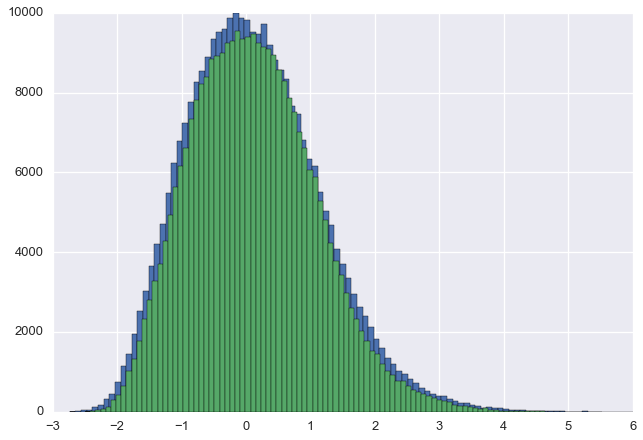

In [1058]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

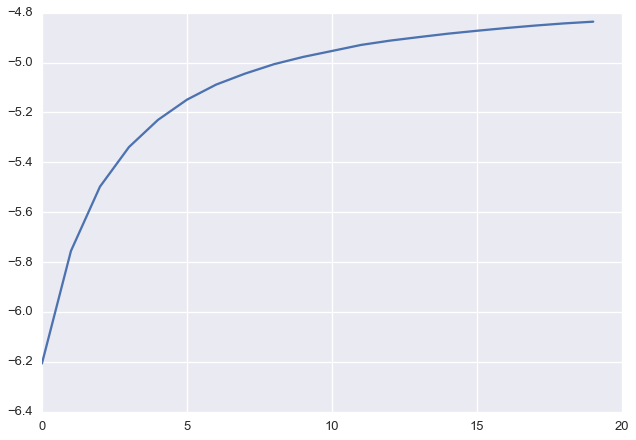

In [1059]:
plt.plot(get_score_list(x_train, y_train[:, 0], est, mape))

In [1060]:
imps = est.feature_importances_
feats = train.columns
df = pd.DataFrame()
df['feature'] = feats
df['importance'] = imps

In [1061]:
df.set_index('feature').sort_values('importance', ascending=False)

,importance
feature,
anc_veh,0.216774
var12,0.149526
annee_permis,0.140392
kmage_annuel,0.097988
marque_25,0.044204
var4,0.043753
var1,0.032075
var5,0.031168
var10,0.025491


In [1062]:
df.set_index('feature').sort_values('importance', ascending=False).index

Index(['anc_veh', 'var12', 'annee_permis', 'kmage_annuel', 'marque_25', 'var4',
       'var1', 'var5', 'var10', 'var18', 'var9', 'annee_naissance', 'crm',
       'marque_size', 'energie_veh_gazole', 'var2', 'var15', 'var22',
       'marque_75', 'var11', 'marque_Mean', 'puis_fiscale', 'var17', 'var7',
       'var19', 'profession_size', 'marque_50', 'var13', 'permis_age', 'var20',
       'var8_25', 'var16', 'profession_75', 'var6_A', 'var6_B', 'var6_C',
       'profession_50', 'profession_25', 'profession_Mean',
       'energie_veh_essence', 'var8_size', 'var21', 'var8_75', 'var8_50',
       'var8_Mean', 'var3', 'var6_D', 'energie_veh_gpl',
       'energie_veh_hybride essence', 'energie_veh_electricite', 'var6_N'],
      dtype='object', name='feature')

С валидацией

In [1077]:
def get_score_list(X, y, clf, scorer, crm, intercepts):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict(X)
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, (rf_prediction + slope) * crm + intercepts))
    return score

In [1079]:
%%time
train_index = 250 * 1000
est = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1).fit(X=x_train[:train_index], y=diff[:train_index])

CPU times: user 16min 33s, sys: 4.53 s, total: 16min 38s
Wall time: 4min 12s


In [1084]:
gc.collect()

9

In [1080]:
diff_pred = est.predict(x_train[train_index:])
y_pred = (diff_pred + slope) * train.crm[train_index:] + intercept
mape(y_train[train_index:, 0], y_pred)

-9.8830383113212399

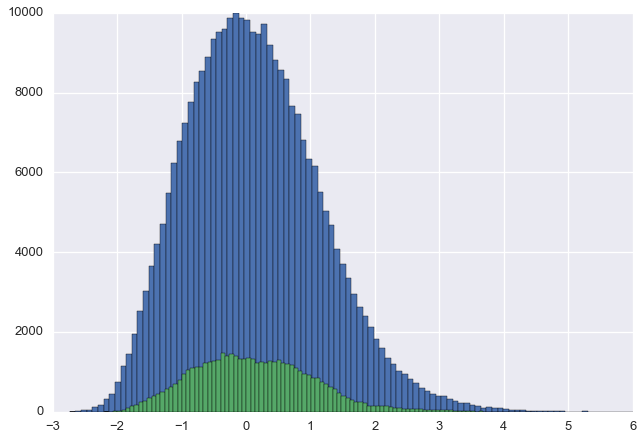

In [1081]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

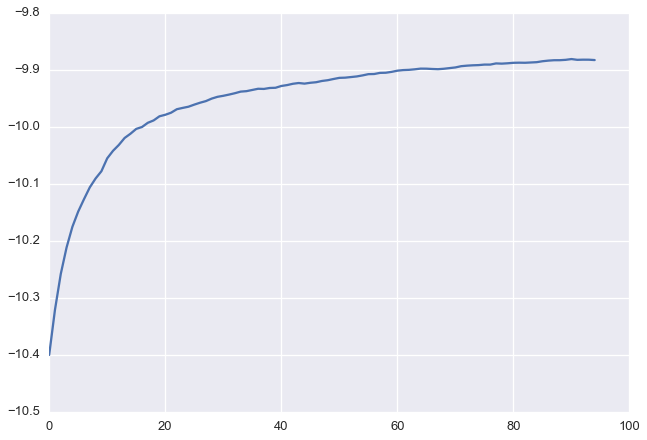

In [1082]:
plt.plot(get_score_list(x_train[train_index:], y_train[train_index:, 0], est, mape, train.crm[train_index:], intercept)[5:])

In [1085]:
est = None
gc.collect()

9

In [1086]:
from sklearn.ensemble import ExtraTreesRegressor

In [1101]:
%%time
train_index = 250 * 1000
est = ExtraTreesRegressor(n_estimators=20, max_depth=None, n_jobs=-1, random_state=42).fit(X=x_train, y=diff)

CPU times: user 3min 4s, sys: 760 ms, total: 3min 5s
Wall time: 47.3 s


In [1102]:
diff_pred = est.predict(x_train)
y_pred = (diff_pred + slope) * train.crm + intercept
mape(y_train[:, 0], y_pred)

-2.4779370396784186

Eto шедевр, сравним с ошибкой при знании ответа

In [1103]:
mape(y_train[:, 0], 60 + train.crm * (slope + diff))

-2.4779370292308642

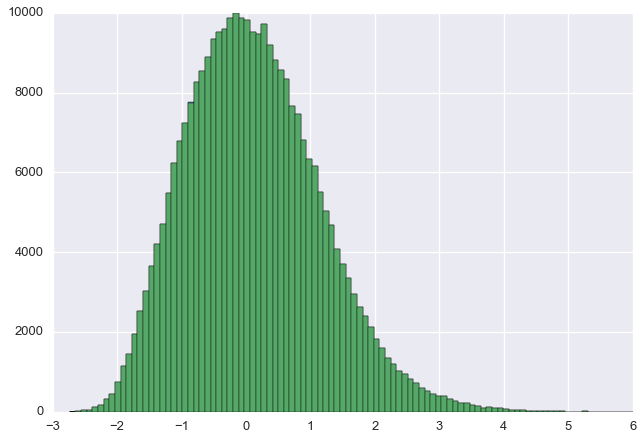

In [1104]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

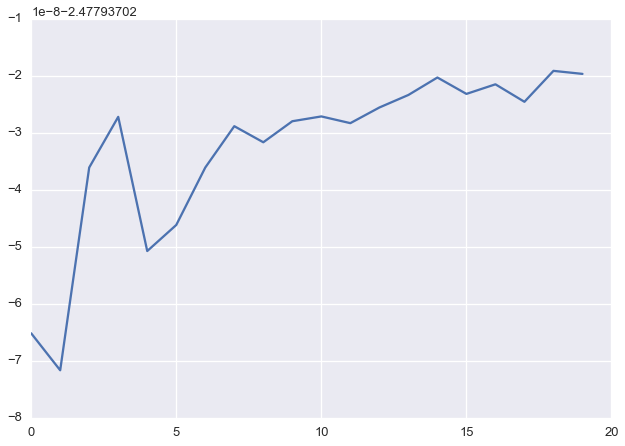

In [1105]:
plt.plot(get_score_list(x_train, y_train[:, 0], est, mape, train.crm, intercept))

Теперь с валидацией

In [1168]:
%%time
train_index = 200 * 1000
est = ExtraTreesRegressor(n_estimators=20, max_features=51, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_train[:train_index], y=diff[:train_index])

CPU times: user 1min 52s, sys: 172 ms, total: 1min 52s
Wall time: 28.4 s


In [1169]:
diff_pred = est.predict(x_train[train_index:])
y_pred = (diff_pred + slope) * train.crm[train_index:] + intercept
mape(y_train[train_index:, 0], y_pred)

-10.224699727078198

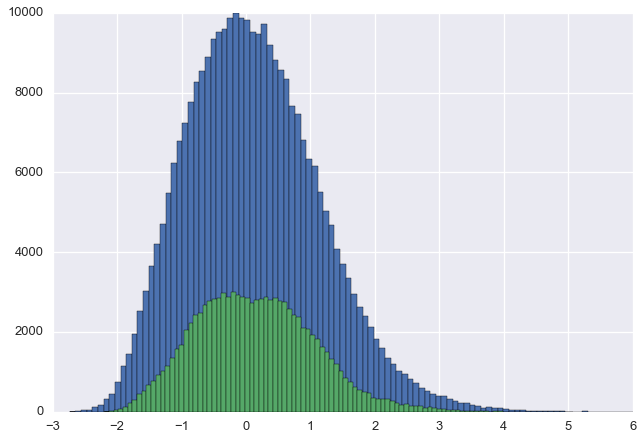

In [1170]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

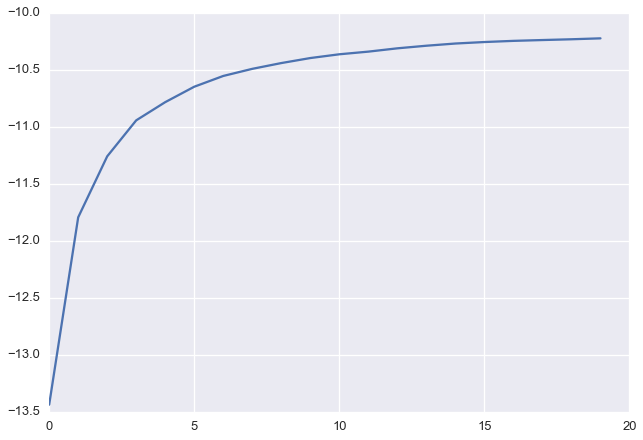

In [1171]:
plt.plot(get_score_list(x_train[train_index:], y_train[train_index:, 0], est, mape, train.crm[train_index:], intercept))

In [1139]:
mape(y_train[train_index:, 0], intercept + train.crm[train_index:] * (slope + diff[train_index:]))

-2.4796028963407624

In [755]:
from sklearn.tree import DecisionTreeRegressor

In [759]:
%%time
train_index = 250 * 1000
est = DecisionTreeRegressor(max_depth=None).fit(X=x_train[:train_index,:], y=diff[:train_index])

CPU times: user 11 s, sys: 16 ms, total: 11 s
Wall time: 11 s


In [760]:
y_pred = (est.predict(x_train[train_index:, :]) + slope) * train.crm[train_index:] + intercept
mape(y_train[train_index:, 0], y_pred)

-12.673579133672281

In [620]:
train.columns[features_index]

Index(['annee_naissance', 'kmage_annuel', 'var4', 'var5', 'var9', 'var10',
       'var12', 'var21', 'var22', 'permis_age', 'energie_veh_electricite',
       'energie_veh_gazole', 'var6_A', 'var6_B', 'var6_C', 'var6_D', 'var6_N',
       'marque_size', 'marque_25', 'marque_50', 'marque_75', 'profession_75',
       'var8_size', 'var8_Mean', 'var8_25', 'var8_50', 'var8_75'],
      dtype='object')

In [621]:
train.columns

Index(['annee_naissance', 'annee_permis', 'puis_fiscale', 'anc_veh',
       'kmage_annuel', 'crm', 'var1', 'var2', 'var3', 'var4', 'var5', 'var7',
       'var9', 'var10', 'var11', 'var12', 'var13', 'var15', 'var16', 'var17',
       'var18', 'var19', 'var20', 'var21', 'var22', 'permis_age',
       'energie_veh_electricite', 'energie_veh_essence', 'energie_veh_gazole',
       'energie_veh_gpl', 'energie_veh_hybride essence', 'var6_A', 'var6_B',
       'var6_C', 'var6_D', 'var6_N', 'marque_size', 'marque_Mean', 'marque_25',
       'marque_50', 'marque_75', 'profession_size', 'profession_Mean',
       'profession_25', 'profession_50', 'profession_75', 'var8_size',
       'var8_Mean', 'var8_25', 'var8_50', 'var8_75'],
      dtype='object')

In [505]:
diff[:10]

ID
1    -0.823706
2     0.174064
3     0.098653
4     1.214312
5    -0.481008
6     1.366024
7     0.887832
8     2.539416
9     0.174064
10   -0.746592
dtype: float64

In [508]:
diff_pred[:10]

array([[-0.8111949 ],
       [ 0.27846012],
       [ 0.15349412],
       [ 0.71575952],
       [-0.54515839],
       [ 0.67067206],
       [ 0.77276742],
       [ 1.22932231],
       [ 0.27846012],
       [ 0.2360228 ]])

In [436]:
def stacking_target(x_train, y_train):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':3,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    num_round = 2
    n_folds = 5
    
    y_pred = np.zeros(y_train.shape)

    label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
    #label_kfold = KFold(n=y_train.shape[0], n_folds=n_folds, shuffle=False, random_state=56)

    for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
        dtrain = xgb.DMatrix(x_train[train_index], 
                             label=y_train[train_index], 
                             missing=-9999,) 
        dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
        param['base_score'] = np.mean(y_train[train_index])
        bst = xgb.train(param, dtrain, num_round)
        y_pred[test_index, 0] = bst.predict(dvalidation)
        gc.collect()
    
    return y_pred

In [437]:
%%time
inters_pred = stacking_target(x_train, inters.reshape(y_train.shape))


CPU times: user 12.1 s, sys: 656 ms, total: 12.8 s
Wall time: 12.8 s


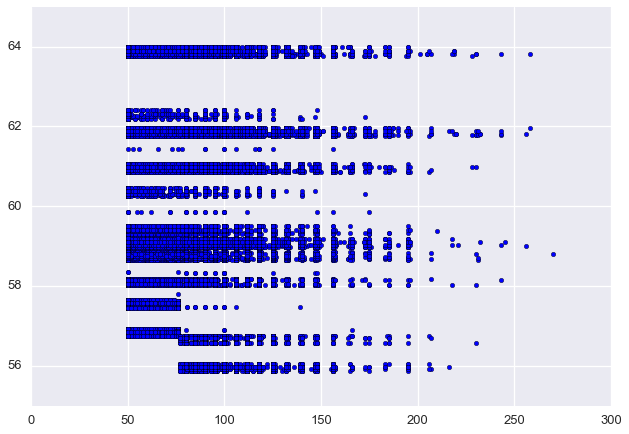

In [438]:
plt.scatter(train.crm, inters_pred)

In [445]:
diff_pred = (dfYtrain.COTIS - 60 - slope * train.crm) / train.crm

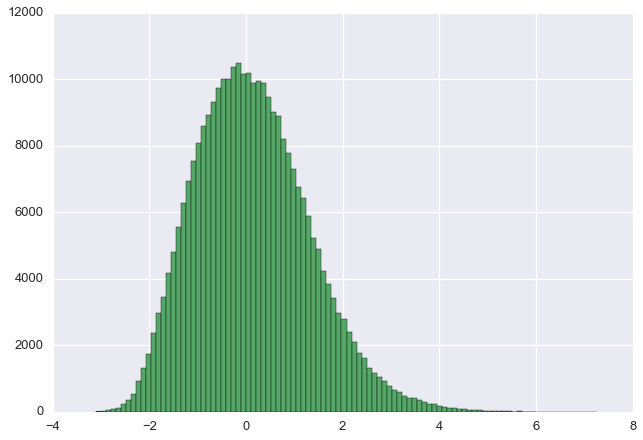

In [446]:
plt.hist(diff, bins=100)
plt.hist(diff_pred, bins=100)
plt.show()

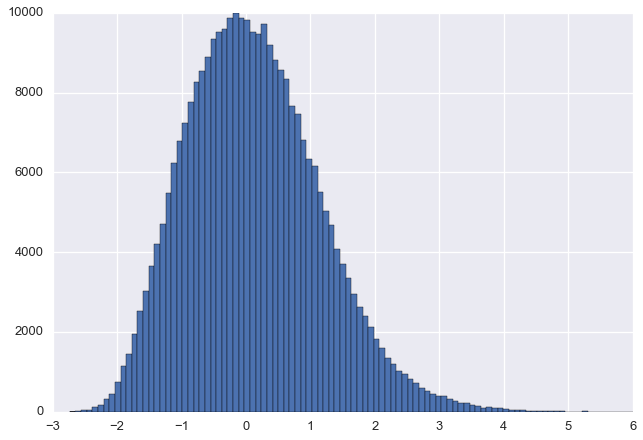

In [448]:
plt.hist(diff, bins=100)
plt.show()

In [419]:
inters = (dfYtrain.COTIS - (slope + diff_pred.reshape(diff.shape)) * train.crm)

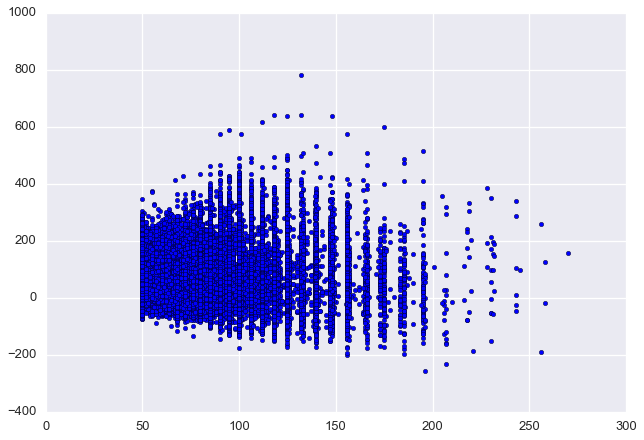

In [420]:
plt.scatter(train.crm, inters)

In [68]:
onex = np.array(onex).reshape(y_train.shape)

In [69]:
%%time

n_folds = 10
label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
weight_list = [w for w in np.arange(0.8, 1.2, 0.005)
               ]
scores = [-100 for i in range(n_folds)]
train_scores = [-100 for i in range(n_folds)]
weights = [0 for i in range(n_folds)]

for fold_index, (train_index, test_index) in enumerate(label_kfold):
    X = onex[train_index]
    y = y_train[train_index][:, 0]
    X_validation = onex[test_index]
    y_validation = y_train[test_index][:, 0]
    good_score = -np.Inf
    good_weight = None
    for weight in weight_list:
        y_pred = X[:, 0] * weight
        score = mape(y, y_pred)
        if score > good_score:
            good_score = score
            good_weight = weight
    y_pred = X_validation[:, 0] * good_weight
    scores[fold_index] = mape(y_validation, y_pred)
    train_scores[fold_index] = good_score
    weights[fold_index] = good_weight   

CPU times: user 2.57 s, sys: 0 ns, total: 2.57 s
Wall time: 2.57 s


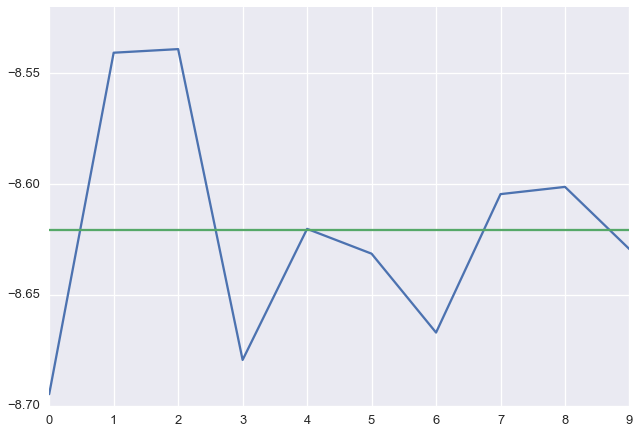

In [70]:
plt.plot(train_scores)
mean = np.mean(train_scores)
plt.plot([mean for i in train_scores])

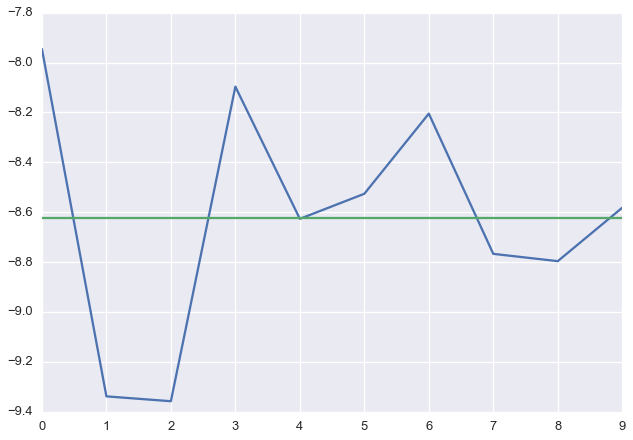

In [71]:
plt.plot(scores)
mean = np.mean(scores)
plt.plot([mean for i in scores])

In [72]:
weights

[0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99000000000000021,
 0.99500000000000022]

In [73]:
mean

-8.624095496134407

# Save

In [74]:
save_to_file_stacking(onex * 0.99, 'xbg_with_size_divided_another.csv')

In [79]:
def test_target(x_train, y_train, x_test):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':9,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    num_round = 140
    dtrain = xgb.DMatrix(x_train, 
                         label=y_train, 
                         missing=-9999,) 
    dtest = xgb.DMatrix(x_test, missing=-9999)
    param['base_score'] = np.mean(y_train)
    bst = xgb.train(param, dtrain, num_round)
    y_pred = bst.predict(dtest)
    gc.collect()
    
    return y_pred

In [80]:
%%time
delta_pred = test_target(x_train, delta, x_test)

CPU times: user 5min 36s, sys: 148 ms, total: 5min 36s
Wall time: 5min 36s


In [81]:
linreg_coef.loc[dropped_test.department.unique()]

,slope,intercept,r_value,p_value,std_err
department,,,,,
971,3.456195,75.761862,0.712962,0.0,0.055905
1,3.979562,71.354886,0.707645,0.0,0.064518
974,NaN,NaN,NaN,NaN,NaN


In [82]:
linreg_coef.mean()

slope         3.412184
intercept    96.561713
r_value       0.677539
p_value       0.000573
std_err       0.082011
dtype: float64

In [83]:
mean_row = linreg_coef.mean()
mean_row

slope         3.412184
intercept    96.561713
r_value       0.677539
p_value       0.000573
std_err       0.082011
dtype: float64

In [84]:
linreg_coef.loc[974] = mean_row

In [85]:
test_table = linreg_coef.loc[dropped_test.department].reset_index().set_index(dropped_test.index)

In [86]:
test_table = pd.concat([test_table, test.crm], axis=1)
test_table.head()

,department,slope,intercept,r_value,p_value,std_err,crm
id,,,,,,,
300001,971.0,3.456195,75.761862,0.712962,0.0,0.055905,88
300002,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50
300003,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50
300004,971.0,3.456195,75.761862,0.712962,0.0,0.055905,68
300005,971.0,3.456195,75.761862,0.712962,0.0,0.055905,50


In [87]:
reset_table = test_table.reset_index()
y_pred = delta_pred * reset_table.crm + reset_table.intercept + reset_table.slope * reset_table.crm

In [88]:
save_to_file(y_pred * 0.99, 'xbg_with_size_divided_mean_another.csv')

In [90]:
y_pred = delta_pred * reset_table.crm + mean_row.intercept + mean_row.slope * reset_table.crm

In [91]:
save_to_file(y_pred * 0.99, 'xbg_with_size_divided_mean_another_crazy.csv')